<a href="https://colab.research.google.com/github/DamianDominoDavis/sommalier/blob/master/sommalier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#V.1 Exploring the green reds
<p>
    <ol type="a">
        <li>Write a function that will plot a scatterplot matrix of your red wine data. Your function should plot wines with quality over some “good_threshold” as one color, and wines below some “bad_threshold” as another. Your plotting function should have the option to save a .png of your plots. Here’s an example function definition: <pre>def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False)</pre></li>
    </ol>
</p>


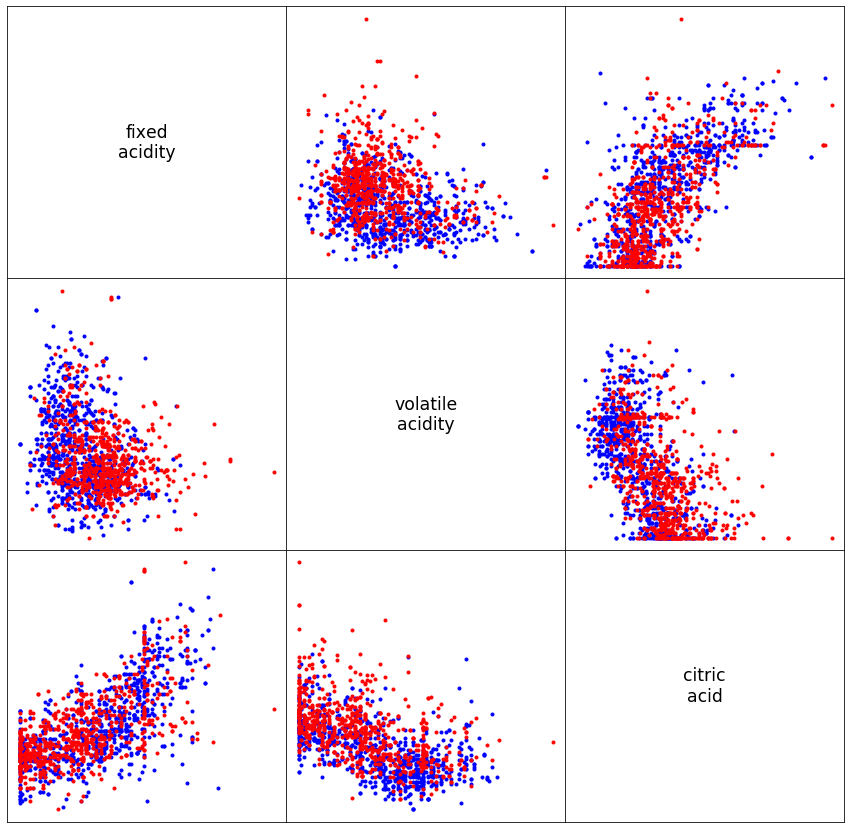

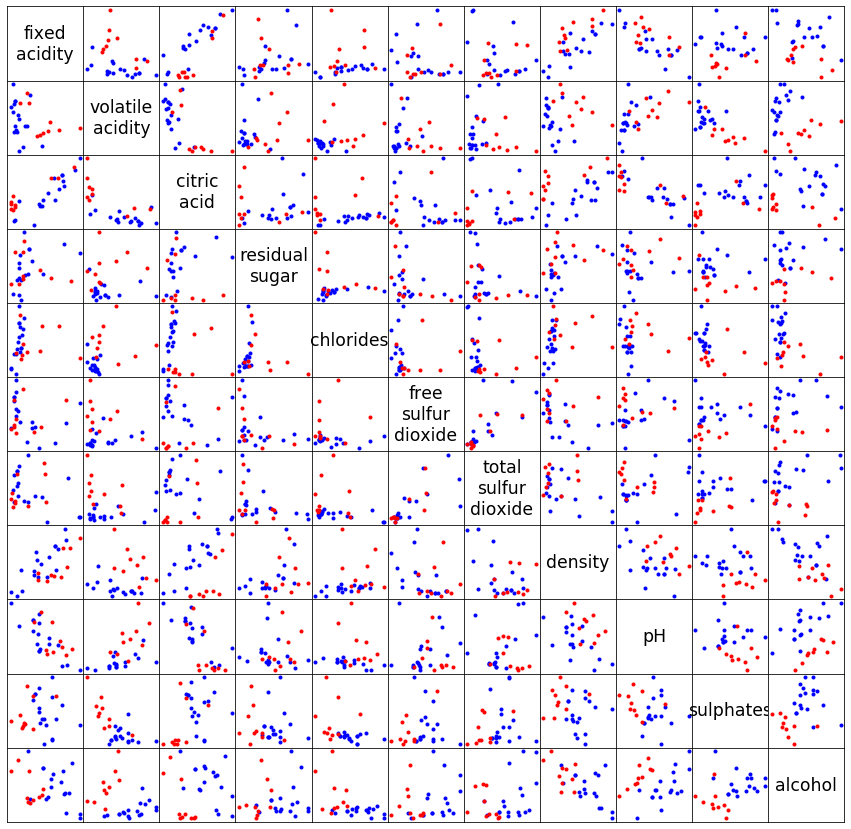

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_scatter_matrix(data, good_threshold, bad_threshold, save=False):
    wine_good = data[data['quality'] >= good_threshold]
    wine_bad = data[data['quality'] <= bad_threshold]
    dimens = tuple([x for x in data if x != 'quality'])
    txt_args = {'size': 'xx-large',
                'horizontalalignment': 'center',
                'verticalalignment': 'center'}
    fig = plt.figure(figsize=[15, 15])
    fig.subplots_adjust(wspace=0, hspace=0)
    ax = fig.subplots(len(dimens), len(dimens))
    for r, rd in enumerate(dimens):
        for c, cd in enumerate(dimens):
            ax[r,c].get_xaxis().set_visible(False)
            ax[r,c].get_yaxis().set_visible(False)
            if r == c:
                ax[r,c].text(0.5, 0.5, rd.replace(' ', '\n'), txt_args)
            else:
                ax[r,c].plot(rd, cd, 'b.', data=wine_good)
                ax[r,c].plot(rd, cd, 'r.', data=wine_bad)
    if save:
        return fig.savefig('wine_plot.png', dpi=100)

url = 'https://raw.githubusercontent.com/DamianDominoDavis/sommalier/master/winequality-red.csv'
csv = pd.read_csv(url, sep=';')
small = csv[['fixed acidity', 'volatile acidity', 'citric acid', 'quality']]
plot_scatter_matrix(small, 6, 5, save=True)
plot_scatter_matrix(csv, 8, 3)


<p>
    <ol type="a" start=2>
        <li>Now that you’ve had a chance to analyze different chemical factors in red wines and their relationship with high scores (8 or higher) and low scores (3 or lower), which factors do you think will be most useful to your perceptron for distinguishing high quality vs. low quality wines? Why?

---
Correlation within good and bad groups is less important than clear distinction between the two. Which, if any, of these axes will be separable depends as much on the threshold selections as the input data. For thresholds 8 and 3, see alcohol/pH/chlorides in the lower-right (all good); compare other axes.</li>
    </ol>
</p>


<h1 color="red">V.2 Learning to perceptron</h1>
<p>
    <ol type="a">
        <li><strong>Implement a perceptron</strong> that:
            <ul><small>
                <li>Has randomly initialized weights and bias</li>
                <li>Uses the Rosenblatt perceptron learning rule (with changeable learning rate)</li>
                <li>Utilizes the heaviside step activation function (discrete version)</li>
            </small></ul>
        </li>
        <li>You’ll need to implement a function to <strong>train your perceptron</strong>. Your training function
should take in your red wine data as a parameter and should:
            <ul><small>
                <li>Have a way to specify number of training epochs</li>
                <li>Train your perceptron until it makes no errors, if training epochs is set to 0,</li>
                <li>Have a way to specify learning rate.</li>
                <li>Return a list of python tuples containing (performance):<br/><pre>[(current_epoch, num_errors_at_epoch_end, [array_of_weights], bias), &hellip; ]</pre></li>
            </small></ul>
        </li>
        <li>Now that you have a perceptron, a way to train your perceptron, and some data, you need a way to confirm that your perceptron actually works. Write a function that will take the output of your perceptron training function and your red wine data and generate two plots in one figure:
            <ul><small>
                <li>The first plot should <strong>plot the number of errors your perceptron made as a function of epoch</strong>. Be careful with how you calculate errors!</li>
                <li>The second plot should <strong>plot the decision boundary</strong> of your perceptron and also show ‘good’ and ‘bad’ wine data points on the final training epoch. This second plot should also shade ‘good’ and ‘bad’ areas!</li>
                <li>Your function should allow the user to specify a <strong>specific epoch</strong> and see what the decision boundary of the perceptron was on that epoch. If a negative epoch is given, cause the plots to show the last epoch.</li>
            </small></ul>
        </li>
        <li>Your perceptron appears to work... but why is it taking so many epochs to train? Maybe you can modify the red wine data to help the perceptron learn more quickly? Use the function you just created in part c) to plot and verify that your perceptron is learning more efficiently! <em><br/>(Data standardization.)</em>
        </li>
    </ol>
</p>


success in 13175 epochs


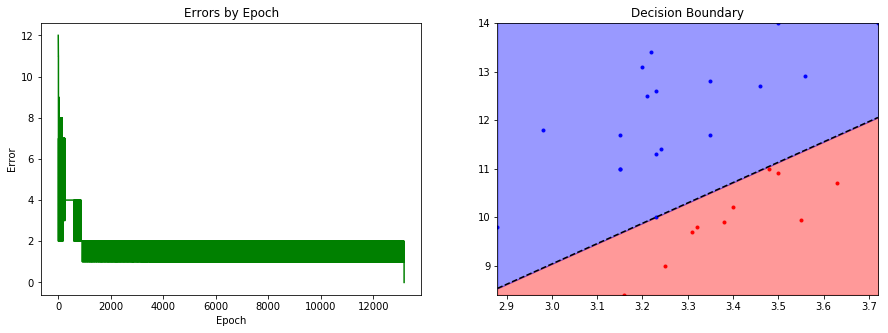

success in 5 epochs


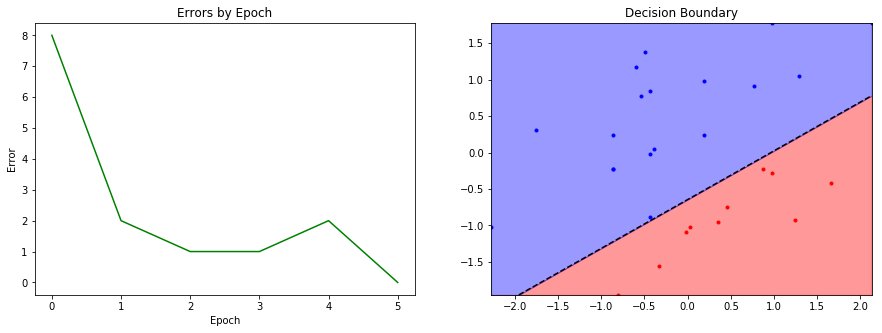

In [49]:
import random
import pandas as pd
import matplotlib.pyplot as plt

class Perceptron(object):
    def __init__(self, data):
        dimens = [x for x in data if x != 'quality']
        self.data = data
        self.dimens = tuple(dimens)
        self.D = len(self.dimens)

    ''' specify learning rate, number of training epochs '''
    def train(self, threshold, rate=0.1, epoch=0):
        story = list()
        ''' randomly initialized weights and bias '''
        bias, weights = random.uniform(-1,1), [random.uniform(-1,1) for d in range(self.D)]
        cur_epoch = 0
        ''' if training epochs is set to 0... '''
        while cur_epoch < epoch or epoch == 0:
            num_errors = 0
            for i in range(len(self.data.index)):
                xi = self.data.iloc[i]
                cmp = bias + sum([weights[d] * xi[self.dimens[d]] for d in range(self.D)])
                '''heaviside step activation'''
                yi = int(cmp > 0)
                error = int(xi.quality >= threshold) - yi
                if error:
                    num_errors += 1
                    '''rosenblatt learning rule'''
                    weights = [weights[w] + error * rate * xi[self.dimens[w]] for w in range(self.D)]
                    bias += error * rate
            story.append(tuple([cur_epoch, num_errors, weights, bias]))
            cur_epoch += 1
            ''' ...train until it makes no errors '''
            if num_errors == 0:
                break
        ''' return a list of tuples '''
        return story

''' specify a specific epoch [specifically] '''
def report(story, data, good_thresh, bad_thresh, epoch=-1, save_plot=False):
    print('{} in {} epochs'.format('success' if story[-1][1] == 0 else 'failed', story[-1][0]))
    tup = story[epoch if 0 <= epoch and epoch <= story[-1][0] else -1]
    a, b = -(tup[3]/tup[2][1])/(tup[3]/tup[2][0]), -(tup[3]/tup[2][1])
    x = [xmin, xmax] = [min(data.pH.values), max(data.pH.values)]
    c = [ya, yb] = [a*xmin + b, a*xmax + b]
    y = [ymin, ymax] = [min(data.alcohol.values), max(data.alcohol.values)]

    fig = plt.figure(figsize=[15, 5])
    ax, bx = fig.subplots(1, 2)
    ax.set_title("Errors by Epoch")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Error")
    ax.plot([e[0] for e in story], [e[1] for e in story], 'g-')
    bx.set_title("Decision Boundary")
    bx.axis([xmin, xmax, ymin, ymax])
    bx.plot(data[data.quality>=gthresh].pH, data[data.quality>=gthresh].alcohol, 'b.')
    bx.plot(data[data.quality<=bthresh].pH, data[data.quality<=bthresh].alcohol, 'r.')
    bx.plot(x, c, "k--")
    bx.fill_between(x, c, ymin, color="red", alpha=.4)
    bx.fill_between(x, c, ymax, color="blue", alpha=.4)
    plt.show() if not save_plot else plt.savefig('fig.png')

''' prep data: pH vs alcohol, excuding rows where 3 < quality < 8 '''
url = 'https://raw.githubusercontent.com/DamianDominoDavis/sommalier/master/winequality-red.csv'
csv = pd.read_csv(url, sep=';')
training = csv[['pH', 'alcohol','quality']]
gthresh, bthresh = 8, 3
training = training[(training['quality'] >= gthresh) | (training['quality'] <= bthresh)]

''' this one is slooOw, and likely to lie on an extreme sample from one or both categories '''
poor = Perceptron(training)
report(poor.train(gthresh), poor.data, gthresh, bthresh)

''' ... feature scaling happens ... '''
dimens = [x for x in training if x != 'quality']
training[dimens] = (training[dimens]-training[dimens].mean()) / training[dimens].std()

''' this one is orders of magnitude faster, and has much fairer odds at being a neat division '''
per = Perceptron(training)
report(per.train(gthresh), per.data, gthresh, bthresh)


<h1>V.3 My fair ADALINE</h1>
<p>Encouraged by the results of your perceptron, you decide to see if you can use it to distinguish between wines with a score of 4 and lower, and wines with a score of 7 and higher. Feeling confident, you decide to let the perceptron train until it can find the best decision boundary.
<ol type="a">
    <li>Marvin notices and chides you for torturing your perceptron. Why? You decide to upgrade your perceptron to handle this harder classification task. You’ve heard a bit about the gradient descent technique and also about ADALINE, maybe these will do the trick? Gradient descent, know it, love it!</li>
    <li>Implement an ADALINE that:
        <ul><small>
            <li>Has randomly initialized weights and bias</li>
            <li>Uses a linear activation function and some kind of quantizer</li>
            <li>Uses the Widrow-Hoff learning rule</li>
        </small></ul>
    </li>
    <li>You’ll need to implement a function to train your ADALINE. Your training function should:
        <ul><small>
            <li>Take in your red wine data as a parameter</li>
            <li>Have a way to specify number of training epochs</li>
            <li>If training epochs is set to 0, your ADALINE should train until it converges on a good set of weights.</li>
            <li>Have a way to specify learning rate.</li>
            <li>Have an option to perform either online learning or batch learning</li>
        </small></ul>
    </li>
    <li>Find a good learning rate for your ADALINE and plot number of classification errors vs. epoch and the decision boundary of your ADALINE. What settings tend to give the smallest number of classification errors? Support your reasoning with example plots!</li>
</ol>
<hr>
<p>Perceptron only works for linearly seprable data, and will take forever trying to fit bad data. Adeline approaches correctness, but can be made to stop sensibly.</p>
<p>Hypersensitive learn rates (1&gt;&asymp;) about immediately accumulate errors faster than precision; we can bail as early as cost rises. For insensitive values closer to 0, time to cost-risen bail lengthens dramatically, and for not a lot of return on precision.</p>


Adaline: learn rate (0.1), batch size (None), time = 3 epochs


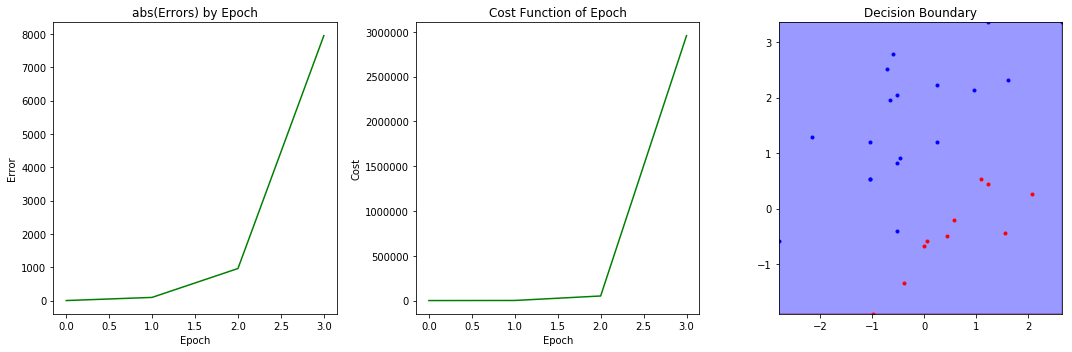

Adaline: learn rate (0.01), batch size (None), time = 101 epochs


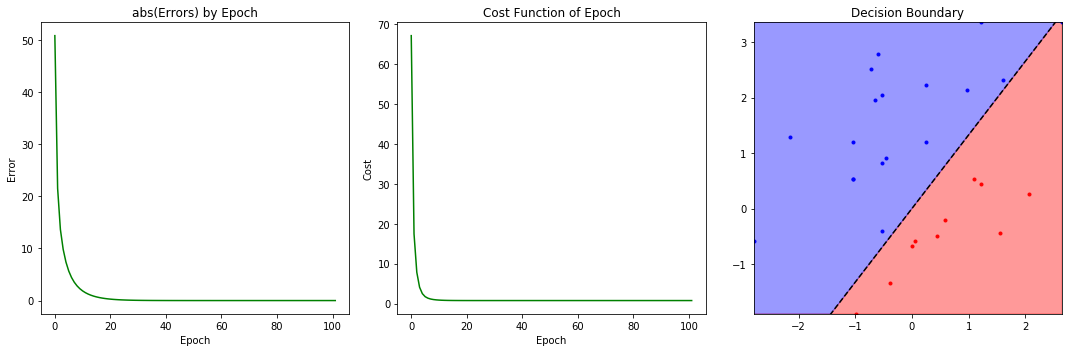

Adaline: learn rate (0.001), batch size (None), time = 990 epochs


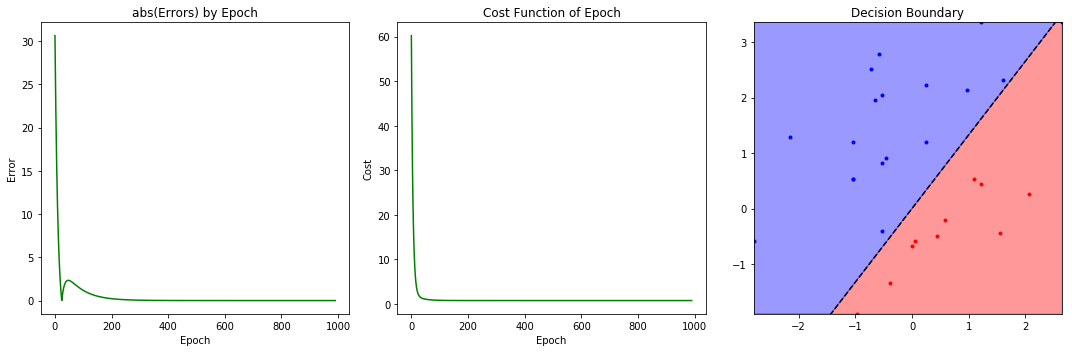

Adaline: learn rate (0.0001), batch size (None), time = 8793 epochs


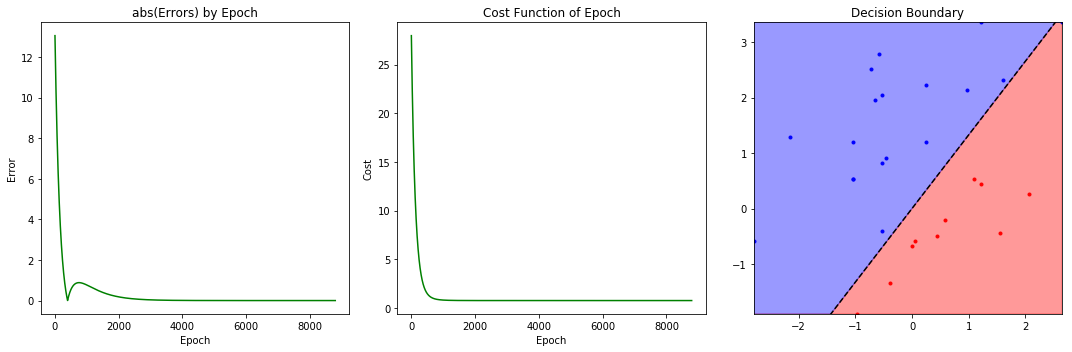

Adaline: learn rate (1e-05), batch size (None), time = 84614 epochs


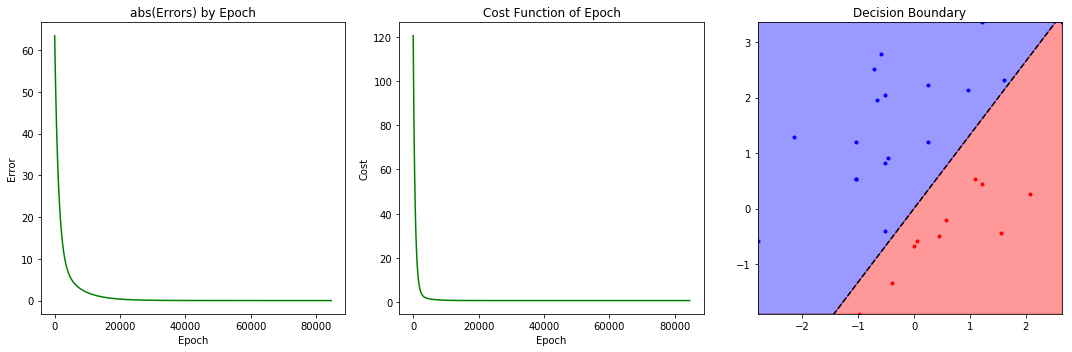

In [65]:
import random, math
import pandas as pd
import matplotlib.pyplot as plt

''' lightweight vector/matrix shorthands '''
''' unnecessary? you bet! I'm forbidden many numpy conveniences. '''
def lst_add(X, w):
    return [x+w for x in X]

def lst_plus_lst(lst1, lst2):
    return [a+b for a,b in zip(lst1,lst2)]

def lst_minus_lst(lst1, lst2):
    return [a-b for a,b in zip(lst1,lst2)]

def lst_mult(X, k):
    return [x * k for x in X]

def transpose(lst):
    return [[row[i] for row in lst] for i in range(len(lst[0]))]

def dot(a, b):
    return [sum(a[row][i]*b[i] for i in range(len(b))) for row in range(len(a))]

def dot_adaline(X, w):
    return [x[0]*w[0] + x[1]*w[1] for x in X]

def h_step_fun(X, good):
    return [int(x>=good) for x in X]

''' Adaline '''
class Adaline(object):
    def __init__(self, lrate=0.001, epoch=0, batch=None):
        if epoch != int(epoch) or epoch < 0:
            raise ValueError("Adaline needs nonnegative int target epoch, not {}".format(epoch))
        self.lrate = lrate
        self.epoch = epoch
        self.batch = batch
    
    def fit(self, X, y):
        self.w = [random.uniform(-1,1) for i in range(1 + X.shape[1])]
        story = list()
        ''' real talk though, this batch stuff is doesn't increase accuracy at this stage. '''
        ''' the logical conclusion is have batch be a managed size that achieves '''
        ''' odd-man-out validation or whatever it's called; and IS NOT USEFUL otherwise. '''
        if self.batch:
            b = list(zip(X, y))
            random.shuffle(b)
            X[:], y[:] = zip(*b)
            X = X[:self.batch]
            y = y[:self.batch]
        e = 0
        while self.epoch == 0 or e < self.epoch:
            output = self.net_input(X)
            expect = h_step_fun(y, 8)
            errors = lst_minus_lst(expect, output)
            self.w[1:] = lst_plus_lst(self.w[1:], lst_mult(dot(transpose(X), errors), self.lrate))
            self.w[0] += self.lrate * sum(errors)
            ''' errors transform into cost '''
            cost = sum(x**2 for x in errors) / 2
            log = (e, sum(errors), self.w[1:], self.w[0], cost)
            story.append(log)
            ''' increasing cost is the new bailout criteria for unlimited epoch '''
            if (self.epoch == 0 and e > 2 and abs(story[e - 1][4]) < abs(story[e][4])):
                break
            e += 1
        self.story = story
        return story
    
    def net_input(self, X):
        return (lst_add(dot(X, self.w[1:]), self.w[0]))
    
    def predict(self, X):
        return [1 if x >= 0 else -1 for x in self.net_input(X)]
    
    def evaluate_accuracy(self, X, y):
        Xb = self.predict(X)
        tot = 0
        for xi, yi in zip(Xb, y):
            tot += (int(xi) == int(yi))
        return 1 - tot / len(y)

''' report now plots cumulative epoch cost '''
def report(story, data, good_thresh, bad_thresh,  epoch=-1, save_plot=False):
    tup = story[epoch if 0 <= epoch <= story[-1][0] else -1]
    w2, w1 = tup[2]
    b = tup[1]
    slope = -w1/w2
    intercept = -b/w2
    good, bad = data[data.quality>=good_thresh], data[data.quality<=bad_thresh]
    x = [xmin, xmax] = [min(data[data.columns[0]].values), max(data[data.columns[0]].values)]
    c = [slope*xi + intercept for xi in x]
    y = [ymin, ymax] = [min(data[data.columns[1]].values), max(data[data.columns[1]].values)]

    fig = plt.figure(figsize=[15, 5])
    ax, bx, cx = fig.subplots(1, 3)
    ax.set_title("abs(Errors) by Epoch")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Error")
    ax.plot([e[0] for e in story], [abs(e[1]) for e in story], 'g-')
    bx.set_title("Cost Function of Epoch")
    bx.set_xlabel("Epoch")
    bx.set_ylabel("Cost")
    bx.plot([e[0] for e in story], [e[4] for e in story], 'g-')
    cx.set_title("Decision Boundary")
    cx.axis([xmin, xmax, ymin, ymax])
    cx.plot(good[good.columns[0]], good[good.columns[1]], 'b.')
    cx.plot(bad[bad.columns[0]], bad[bad.columns[1]], 'r.')
    cx.plot(x, c, "k--")
    cx.fill_between(x, c, ymin, color="red", alpha=.4)
    cx.fill_between(x, c, ymax, color="blue", alpha=.4)
    plt.tight_layout()
    plt.show() if not save_plot else plt.savefig('fig.png')

def data():
    url = 'https://raw.githubusercontent.com/DamianDominoDavis/sommalier/master/winequality-red.csv'
    df = pd.read_csv(url, sep=';')
    cols = [d for d in df if d != 'quality']
    df[cols] = (df[cols] - df[cols].mean()) / df[cols].std()
    return df

def demo(lrate, columns=['pH', 'alcohol'], ep=-1, batch=None):
    df = data()
    df = df[(df.quality >= 8) | (df.quality <= 3)]
    ada = Adaline(lrate)
    ada.fit(df[columns].values, df['quality'].values)
    print("Adaline: learn rate ({}), batch size ({}), time = {} epochs".format(lrate, batch, ada.story[-1][0]))
    report(ada.story, df[columns+['quality']], 8, 3, ep)

for lrate in [10**(-p) for p in range(1,6)]:
    demo(lrate)


<h1>V.4 Advanced wine sampling and resampling</h1>
<p>So far, you’ve been using all your data to train your ADALINE. Training your ADALINE many times on a dataset improves its performance for that dataset. But, too much training can lead to overfitting. This can lead to poor performance when the ADALINE encounters new data it has never seen before. Using a validation set and/or cross-validation methodologies reduces (but doesn’t completely eliminate!) the possibility of overfitting!
<ol type="a">
    <li>Write a <strong>function</strong> that uses the holdout method to partition the red wine data into a training and a validation set. The function should take a parameter to adjust the proportion of training to validation data. It should return a tuple containing:
        <pre>(training_pandas_dataframe, validation_pandas_dataframe)</pre></li>
    <li>Write a <strong>function</strong> that generates a k-fold cross-validation dataset from the red wine data. The function should allow k to be arbitrarily adjusted and also have an optional setting to shuffle data before creating k-folds. The function should return a list of ‘k’ tuples with each tuple containing:
        <pre>(training_pandas_dataframe, validation_pandas_dataframe)</pre></li>
    <li>What effects does changing learning rate and number of training epochs have on the
ADALINE when evaluated via k-fold cross-validation? To address this question,
you should write (or modify) a function that will train and assess the ADALINE
on each training and cross-validation fold produced by your k-fold function.</li>
</ol>
<hr>
<p>Previous justification for learn rates reproduced to less effect; sensitivity too close to 1 causes the adeline to fail from speed of error accumulation, sensitivity too close to 0 lengthens bail epoch time without better precision for time. The sweet spot between reliability and execute time appears to be on the order of 1e-4.</p>

4.341692789968652
Rate:0.001, Epoch:29, alcohol x pH


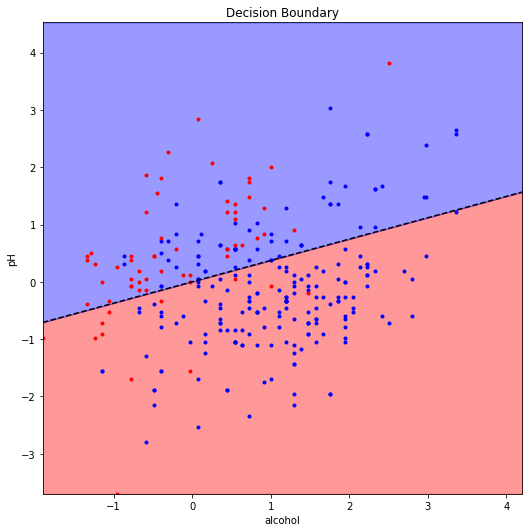

86.83% overall testing accuracy



In [64]:
''' define errors? did you run the Adeline class code cell? '''


''' convenience fetch scaled wine data; optional quality filters '''
def data(good=None, bad=None):
    url = 'https://raw.githubusercontent.com/DamianDominoDavis/sommalier/master/winequality-red.csv'
    df = pd.read_csv(url, sep=';')
    cols = [d for d in df if d != 'quality']
    df[cols] = (df[cols] - df[cols].mean()) / df[cols].std()
    if good and bad:
        df = df[df['quality'] >= good | df['quality'] <= bad]
    return df

''' returns a tuple of dataframes, the second subtracted from the first, '''
''' respectively (1-perc_held) and perc_held times input dataframe in length '''
def holdout(perc_held, shuffle=True):
    df = data() if not shuffle else data().sample(frac=1)
    mask = [bool(x < perc_held*len(df)) for x in range(len(df))]
    return df[[not m for m in mask]], df[mask]

''' returns a k-long list of equally-sized non-overlapping training,holdout dataframe tuples '''
''' output makes up (N - N%k) rows of the input set, at least (k-1)/k percent coverage. '''
''' (it means low values of k are going to be unreliable, be careful.) '''

''' note to self: precache N-N//k as budget;'''
''' rotate mask an extra randrange(0,budget) per rotation and tick down budget as we go '''
def kfold(k=5, shuffle=True):
    df = data() if not shuffle else data().sample(frac=1)
    width = len(df)//k
    mask = [bool(x < width) for x in range(len(df))]
    trains, holds = list(), list()    
    for i in range(k):
        holds.append(df[mask])
        trains.append(df[[not m for m in mask]])
        mask = mask[width:] + mask[:width]
    return list(zip(trains, holds))

''' note to self: here's a good spot for odd-man-out validation or wetf it's called '''

def kreport(story, data, good_thresh, bad_thresh, c, epoch=-1, save_plot=False):
    data = data[c+['quality']]
    good, bad = data[data['quality']>=good_thresh], data[data['quality']<=bad_thresh]
    tup = story[epoch if 0 <= epoch <= story[-1][0] else -1]
    w2, w1 = tup[2]
    b = tup[1]
    slope = -w1/w2
    intercept = -b/w2
    x = [xmin, xmax] = [min(data[c[0]].values), max(data[c[0]].values)]
    y = [ymin, ymax] = [min(data[c[1]].values), max(data[c[1]].values)]
    k = [slope*xi + intercept for xi in x]

    fig = plt.figure(figsize=[7.5, 7.5])
    cx = fig.subplots(1, 1)
    cx.set_title("Decision Boundary")
    cx.set_xlabel(c[0])
    cx.set_ylabel(c[1])
    cx.axis([xmin, xmax, ymin, ymax])
    cx.plot(good[c[0]], good[c[1]], 'b.')
    cx.plot(bad[[c[0]]], bad[c[1]], 'r.')
    cx.plot(x, k, "k--")
    cx.fill_between(x, k, ymin, color="red", alpha=.4)
    cx.fill_between(x, k, ymax, color="blue", alpha=.4)
    plt.tight_layout()
    plt.show() if not save_plot else plt.savefig('fig.png')

def ktrain(df, lrate, good, bad, columns):
    big_weight = [0] * len(columns)
    big_bias = 0
    big_error = 0
    for t,h in df:
        X, y = t[columns].values, t['quality'].values
        ada = Adaline(lrate)
        ada.fit(X, y)
        X, y = h[columns].values, h['quality'].values
        ''' RIGHT HERE THIS IS WHERE THE PREDICT STEP IS BROKEN '''
        big_error += ada.evaluate_accuracy(X, h_step_fun(y,good))
        big_bias += ada.w[0]
        big_weight = [big_weight[i] + ada.w[i+1] for i in range(len(big_weight))]
        
    big_bias /= len(df)
    big_weight = [w/len(df) for w in big_weight]
    print(big_error)
    big_error /= len(df)
    print("Rate:{}, Epoch:{}, {}".format(lrate, ada.story[-1][0], ' x '.join(columns)))
    for c2 in range(len(columns)):
        for c1 in range(c2):
            kreport([(0,0,big_weight,big_bias,big_error)], data(), good,bad, columns)
    ada.w = [big_bias] + big_weight
    print('{:5.2f}% overall testing accuracy'.format(100*big_error))

ada = ktrain(kfold(), 0.001, 7, 4, ['alcohol','pH'])
print()

# V.5 Adventures in the Nth dimension
Up until now, you’ve used only two factors in the wine data to train your perceptron and ADALINE. You wonder if it is possible to train your perceptron or ADALINE with even more chemical factors as inputs. . .
- Try training your perceptron/ADALINE with different numbers and types of chemical factors. Under what circumstances can your perceptron/ADALINE successfully train?
- You know what the decision boundary for 2 wine chemical factors looks like, but what does the decision boundary for 3 factors look like? What about if you use 7 factors? How about if you use all 11 wine chemical factors?
---
Adeline is happy to train on any number of dimensions, but they'll need separable intersections between them.

A boundary is a hyperplane in N dimensions. 2d graphs for two axes, 3d graphs for three axes, animated 3d graphs for 4, and forget it after that, map it down into something visual for humans.


# V.6 Marvin's rebuttal
Although you’ve managed to do a pretty decent job at predicting red wine quality given chemical characteristics, Marvin is not impressed. He gives you one more dataset for Pan-Galactic Gargle Blaster and challenges you to solve it with your single perceptron or ADALINE.

- While not a wine. . . find a way to successfully classify the Pan-Galactic Gargle Blaster dataset. Show that your perceptron or ADALINE successfully classifies the PanGalactic Gargle Blaster data set by plotting the decision boundary and also show ‘good’ and ‘bad’ Gargle Blaster data points.

Resources:
- https://www.youtube.com/watch?v=Y6RRHw9uN9o
- https://www.youtube.com/watch?v=_PwhiWxHK8o
- https://towardsdatascience.com/https-medium-com-pupalerushikesh-svm-f4b42800e989